In [1]:
import sys
sys.path.insert(0, '/users/fs2/hmehri/pythonproject/Thesis/synthetic')
import pandas as pd
import matplotlib.pyplot as plt
from lib.prepare_data import preprocess_data_czech
from lib.eval import comapre_unidist_cont, compute_ngram_metrics, comapre_unidist_cat, compute_2d_categorical_metrics

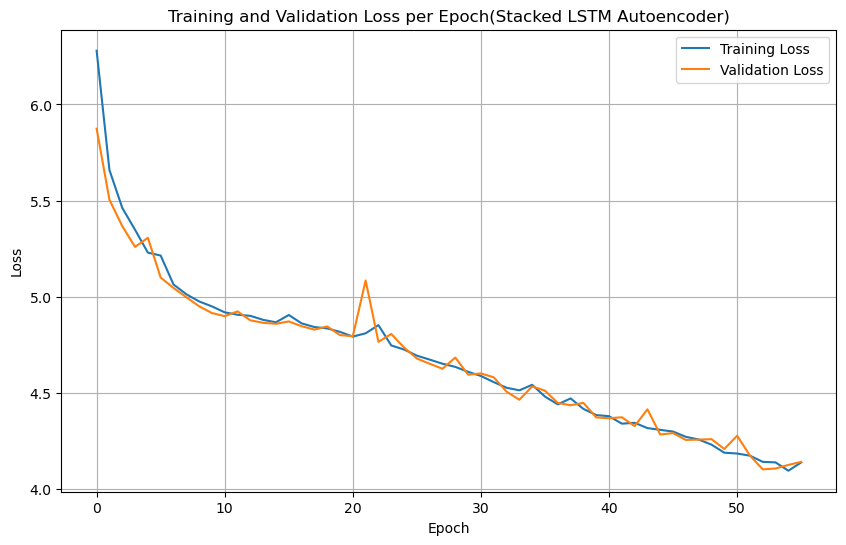

In [2]:
result = pd.read_csv('../lstmModel/results.csv')
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(result['loss'], label='Training Loss')
plt.plot(result['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch(Stacked LSTM Autoencoder)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
raw_data = pd.read_csv('../DATA/tr_by_acct_w_age.csv')
raw_data = raw_data.sort_values(by = ["account_id", "date"])
data, LOG_AMOUNT_SCALE, TD_SCALE,ATTR_SCALE, START_DATE, TCODE_TO_NUM, NUM_TO_TCODE = preprocess_data_czech(raw_data)
real = data[['account_id','tcode', 'datetime','year', 'month', 'dow', 'day','td', 'dtme', 'amount', 'raw_amount']]
real_cf = real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
real_sorted = real.sort_values(['account_id', 'year', 'month', 'day'])
real

,account_id,tcode,datetime,year,month,dow,day,td,dtme,amount,raw_amount
0,1,CREDIT__CREDIT IN CASH__nan,1995-03-24,1995,3,4,24,0.0,7,1000.0,1000.0
1,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-04-13,1995,4,3,13,20.0,17,3679.0,3679.0
2,1,CREDIT__CREDIT IN CASH__nan,1995-04-23,1995,4,6,23,10.0,7,12600.0,12600.0
3,1,CREDIT__nan__INTEREST CREDITED,1995-04-30,1995,4,6,30,7.0,0,19.2,19.2
4,1,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1995-05-13,1995,5,5,13,13.0,18,3679.0,3679.0
...,...,...,...,...,...,...,...,...,...,...,...
1056315,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-02,1998,12,2,2,2.0,29,25600.0,-25600.0
1056316,11382,CREDIT__COLLECTION FROM ANOTHER BANK__nan,1998-12-10,1998,12,3,10,8.0,21,46248.0,46248.0
1056317,11382,DEBIT__CASH WITHDRAWAL__nan,1998-12-25,1998,12,4,25,15.0,6,6300.0,-6300.0
1056318,11382,CREDIT__nan__INTEREST CREDITED,1998-12-31,1998,12,3,31,6.0,0,311.3,311.3


In [7]:
synth_bf = pd.read_csv('../DATA/banksformer_ecml.csv')
synth_bf = synth_bf[['amount', 'date', 'tcode', 'account_id','days_passed']]
synth_bf = synth_bf.rename(columns={'days_passed': 'td'})
# Convert the 'date' column to datetime type
synth_bf['date'] = pd.to_datetime(synth_bf['date'])

# Extract year, month, and day into separate columns
synth_bf['year'] = synth_bf['date'].dt.year
synth_bf['month'] = synth_bf['date'].dt.month
synth_bf['day'] = synth_bf['date'].dt.day

synth_bf['type'] = synth_bf['tcode'].str.split('__').str[0]
synth_bf['raw_amount'] = synth_bf.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synthbf_sorted = synth_bf.sort_values(['account_id', 'year', 'month', 'day'])
synthbf_cf = synth_bf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
synth_bf = synth_bf[['amount', 'tcode', 'account_id', 'td', 'date','month', 'day', 'type', 'raw_amount']]


In [7]:
#synth = pd.read_csv('../DATA/synth_transformer_v3.csv')
synth = pd.read_csv('synth_transformer.csv')
synth.rename(columns={'days_passed': 'td', 'transaction_code': 'tcode'}, inplace=True)
synth['type'] = synth['tcode'].str.split('__').str[0]
synth['raw_amount'] = synth.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)

synth_sorted = synth.sort_values(['account_id', 'year', 'month', 'day'])

synth_cf = synth[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


In [10]:
synth

,amount,tcode,account_id,year,month,day,date,td,type,raw_amount
0,0.00,DEBIT__CASH WITHDRAWAL__SANCTION INTEREST,0,1995,8,31,1995-08-31,0,DEBIT,-0.00
1,0.00,DEBIT__REMITTANCE TO ANOTHER BANK__nan,0,1995,9,4,1995-09-04,4,DEBIT,-0.00
2,0.40,CREDIT__nan__INTEREST CREDITED,0,1995,11,30,1995-11-30,87,CREDIT,0.40
3,6.32,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0,1995,12,31,1995-12-31,31,DEBIT,-6.32
4,72.83,CREDIT__nan__INTEREST CREDITED,0,1995,12,31,1995-12-31,0,CREDIT,72.83
...,...,...,...,...,...,...,...,...,...,...
399995,9.85,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,4999,1996,6,30,1996-06-30,0,DEBIT,-9.85
399996,4834.04,CREDIT__CREDIT IN CASH__nan,4999,1996,6,30,1996-06-30,0,CREDIT,4834.04
399997,726.43,DEBIT__CREDIT CARD WITHDRAWAL__nan,4999,1996,6,30,1996-06-30,0,DEBIT,-726.43
399998,8.71,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,4999,1996,6,30,1996-06-30,0,DEBIT,-8.71


In [8]:
# Wasserstein-1 distances for univariate amount (Amt) and Cash Flow
# the column names of continous features
CONT_FIELDS = ["amount", "td"]

CF_FIELD = 'raw_amount'

#compare univariate distribution of continuous columns
comapre_unidist_cont(CONT_FIELDS,CF_FIELD, real, synth, real_cf, synth_cf)

{'amount': {'wasser': 4564.934482134087,
  'ks': 0.30534448424719784,
  'energy_d': 39.58732802301924},
 'td': {'wasser': 0.35675433050590744,
  'ks': 0.044043496667676374,
  'energy_d': 0.13604774520100368},
 'CF': {'wasser': 4564.130462412367,
  'ks': 0.15896831223596314,
  'energy_d': 26.185105395764275}}

In [9]:
# JSD between the distributions of tcode 3-grams
combo_df, result = compute_ngram_metrics(real_sorted, synth_sorted, 'tcode', 3)
result

{'jsd': 0.07212294052796447,
 'entr_r': 5.425261658301509,
 'entr_g': 5.180364741014083,
 'NED': 0.24489691728742624,
 'l1': 0.5585953514562688,
 'l2': 0.04887503211102127,
 'jac': 0.38612199216564075,
 'count_r': 1431,
 'coverage_r': 0.349365234375,
 'count_g': 1453,
 'coverage_g': 0.354736328125,
 'count_max': 4096,
 'field': 'tcode',
 'n': 3,
 'pseudo_counts': 0.0}

In [10]:
# JSD result comparing the univariate distributions of the tcode (Tcode), and DOM
CAT_FIELDS = ['tcode', 'day', 'month']
result_jst_cat = {}
for field in CAT_FIELDS:
    result_jst_cat[field] = comapre_unidist_cat(real, synth, field)
result_jst_cat

{'tcode': 0.016898760195834688,
 'day': 0.008482433329560269,
 'month': 0.001334146458009913}

In [11]:
#joint distribution of two categorical columns(tcode, DOM)
field1 = 'tcode'
field2 = 'day'
compute_2d_categorical_metrics(real, synth, field1, field2)

{'jsd': 0.0337648215833838,
 'entr_r': 4.31435150199439,
 'entr_g': 4.1892722643821685,
 'l1': 0.3266110421084517,
 'l2': 0.039304264471736836,
 'jac': 0.4425,
 'count_r': 240.0,
 'coverage_r': 0.4838709677419355,
 'count_g': 383.0,
 'coverage_g': 0.7721774193548387,
 'count_max': 496}

In [9]:
synth

,amount,transaction_code,account_id,year,month,day,date,days_passed,td,tcode
0,948.05,DEBIT__CASH WITHDRAWAL__nan,0,1995,9,7,1995-09-07,0,0,DEBIT__CASH WITHDRAWAL__nan
1,1316.63,DEBIT__CASH WITHDRAWAL__nan,0,1995,9,8,1995-09-08,1,1,DEBIT__CASH WITHDRAWAL__nan
2,3142.01,CREDIT__CREDIT IN CASH__nan,0,1995,9,11,1995-09-11,3,3,CREDIT__CREDIT IN CASH__nan
3,2017.99,CREDIT__CREDIT IN CASH__nan,0,1995,9,17,1995-09-17,6,6,CREDIT__CREDIT IN CASH__nan
4,24.34,CREDIT__nan__INTEREST CREDITED,0,1995,9,30,1995-09-30,13,13,CREDIT__nan__INTEREST CREDITED
...,...,...,...,...,...,...,...,...,...,...
399995,3896.74,DEBIT__CASH WITHDRAWAL__nan,4999,1998,6,25,1998-06-25,6,6,DEBIT__CASH WITHDRAWAL__nan
399996,4403.67,DEBIT__CASH WITHDRAWAL__nan,4999,1998,6,28,1998-06-28,3,3,DEBIT__CASH WITHDRAWAL__nan
399997,162.98,CREDIT__nan__INTEREST CREDITED,4999,1998,6,30,1998-06-30,2,2,CREDIT__nan__INTEREST CREDITED
399998,16.13,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,4999,1998,6,30,1998-06-30,0,0,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT


In [2]:
from prepare_data import preprocess_data_czech
from field_info import FieldInfo
from tensor_encoder import TensorEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from train import Train
import tensorflow as tf
from modules import Transformer
import time
import json

def load_config(config_path):
    with open(config_path, 'r') as file:
        config = json.load(file)
    return config

def make_batches(ds, buffer_size, batch_size):
    return ds.cache().shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

def create_tensor_dataset(encoder,bs, split=True):
    """bs is Batch Size
       if split=True, the input data is split into train and validation, otherwise the whole data is used for training """
    n_seqs, _, _ = encoder.inp_tensor.shape

    x_tr, x_cv, inds_tr, inds_cv, targ_tr, targ_cv = train_test_split(encoder.inp_tensor, np.arange(n_seqs), encoder.tar_tensor, test_size=0.2)

    # Create TensorFlow dataset
    ds_all = tf.data.Dataset.from_tensor_slices((encoder.inp_tensor.astype(np.float32), encoder.tar_tensor.astype(np.float32)))
    ds_tr = tf.data.Dataset.from_tensor_slices((x_tr.astype(np.float32), targ_tr.astype(np.float32)))
    ds_cv = tf.data.Dataset.from_tensor_slices((x_cv.astype(np.float32), targ_cv.astype(np.float32)))

    BUFFER_SIZE = ds_all.cardinality().numpy()

    all_batches =   make_batches(ds_all, BUFFER_SIZE, bs)
    train_batches = make_batches(ds_tr, BUFFER_SIZE, bs)
    val_batches =  make_batches(ds_cv, BUFFER_SIZE, bs)

    if split:
        return train_batches, val_batches
    else:
        return all_batches

In [3]:
confighyper = load_config('config_hyper.json')

max_seq_len = confighyper['max_seq_len']
min_seq_len = confighyper['min_seq_len']
batch_size = confighyper['batch_size']
d_embedding = confighyper['d_embedding']
dff = confighyper['dff']
d_model = confighyper['d_model']
maximum_position_encoding = confighyper['maximum_position_encoding']
rate = confighyper['rate']
num_heads = confighyper['num_heads']
num_layers = confighyper['num_layers']   # number of decoder layers that is stacked in transformer's Decoder
epochs = confighyper['epochs'] 
early_stop = confighyper['early_stop'] 
len_generated_seq = confighyper['len_generated_seq'] 
num_generated_seq = confighyper['num_generated_seq'] 
synth_data_filename = confighyper["synth_data_filename"]


raw_data = pd.read_csv('../DATA/tr_by_acct_w_age.csv')
data, LOG_AMOUNT_SCALE, TD_SCALE,ATTR_SCALE, START_DATE, TCODE_TO_NUM, NUM_TO_TCODE = preprocess_data_czech(raw_data)
selected_data_columns = data[['account_id','age','age_sc', 'tcode', 'tcode_num', 'datetime', 'month', 'dow', 'day','td', 'dtme', 'log_amount','log_amount_sc','td_sc']]
df= selected_data_columns.copy()

n_tcodes = len(TCODE_TO_NUM)

info = FieldInfo(n_tcodes)


encoder = TensorEncoder(df, info, max_seq_len, min_seq_len)
encoder.encode()

n_seqs, seq_len, n_feat_inp = encoder.inp_tensor.shape
raw_features = encoder.tar_tensor.shape[-1]    #7

train_batches, val_batches = create_tensor_dataset(encoder,batch_size, split=True)

ACTIVATIONS = {
"td_sc": "relu",
"log_amount_sc": "relu"
}
fieldInfo = FieldInfo(n_tcodes)
config = {}
config["ORDER"] = fieldInfo.DATA_KEY_ORDER
config["FIELD_STARTS_IN"] = fieldInfo.FIELD_STARTS_IN
config["FIELD_DIMS_IN"] = fieldInfo.FIELD_DIMS_IN
config["FIELD_STARTS_NET"] = fieldInfo.FIELD_STARTS_NET
config["FIELD_DIMS_NET"] = fieldInfo.FIELD_DIMS_NET
config["ACTIVATIONS"] = ACTIVATIONS


transformer = Transformer(n_feat_inp, dff, d_embedding, d_model, maximum_position_encoding,num_heads, num_layers,config, rate=0.1)

train = Train(transformer)


2023-12-12 10:26:04.261554: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-12 10:26:04.262768: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-12 10:26:04.314372: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-12-12 10:26:04.314556: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2023-12-12 10:26:04.314574: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-12-12 10:2

Finished encoding 2000 of 14354 seqs
Finished encoding 4000 of 14354 seqs
Finished encoding 6000 of 14354 seqs
Finished encoding 8000 of 14354 seqs
Finished encoding 10000 of 14354 seqs
Finished encoding 12000 of 14354 seqs
Finished encoding 14000 of 14354 seqs
Took 34.48 secs


In [4]:
train.train(train_batches, val_batches, epochs, early_stop)

2023-12-12 10:26:51.368123: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Epoch 1 Batch0 Loss 12.7084
Epoch 1 Batch50 Loss 8.1865
Epoch 1 Batch100 Loss 7.2736
Epoch 1 Batch150 Loss 6.8267
Epoch 1 Loss 6.6359
** on validation data loss is 5.5576
Time taken for 1 epoch: 12.55 secs

Epoch 2 Batch0 Loss 5.4872
Epoch 2 Batch50 Loss 5.3811
Epoch 2 Batch100 Loss 5.2278
Epoch 2 Batch150 Loss 5.1029
Epoch 2 Loss 5.0468
** on validation data loss is 4.7342
Time taken for 1 epoch: 12.15 secs

Epoch 3 Batch0 Loss 4.7417
Epoch 3 Batch50 Loss 4.6333
Epoch 3 Batch100 Loss 4.5527
Epoch 3 Batch150 Loss 4.4851
Epoch 3 Loss 4.4489
** on validation data loss is 4.2615
Time taken for 1 epoch: 12.15 secs



In [12]:
attributes = encoder.attributes
synth = train.generate_synthetic_data(len_generated_seq, num_generated_seq, df, attributes, n_feat_inp)

In [ ]:
with  tf.device('/gpu:0'):
    train.train(train_batches, val_batches, epochs, early_stop)
    attributes = encoder.attributes
    synth = train.generate_synthetic_data(len_generated_seq, num_generated_seq, df, attributes, n_feat_inp)
    
    synth.to_csv(synth_data_filename, index=False)
    print('finish')